# Data augmentation

The purpose of this notebook is to create a model that predicts the factor by which collision rates are reduced by installing speed humps on a given street. The training set will consist of streets that currently have speed humps. I will use this model to augment the data that we currently have by predicting how many crashes a given street would have if speed humps were installed. These are the features that I will use:

- Number of crashes before and after speed humps were installed
- Traffic volume counts
- Presence of bike lanes
- Number of trees
- Road length
- Road width
- Speed limits

### Data manipulation

In [1]:
import sys

sys.path.insert(0, "../")

In [2]:
from dotenv import load_dotenv
from data_downloader import OpenDataDownloader
import os

load_dotenv()

nyc_app_token = os.getenv("NYC_OPENDATA_APPTOKEN")

In [3]:
data_loader = OpenDataDownloader(nyc_app_token)

In [4]:
from pathlib import Path

DATA_PATH = Path("../data")

In [5]:
import data_sources
import geo

TRAFFIC_VOLUMES_PATH = DATA_PATH / "traffic_volumes.csv"
CENTERLINE_PATH = DATA_PATH / "centerline.csv"
TREES_PATH = DATA_PATH / "trees.csv"
SPEED_LIMITS_PATH = DATA_PATH / "speed.csv"

if TRAFFIC_VOLUMES_PATH.exists():
    traffic_vols = data_loader.load_geo_dataframe(
        load_from_file=TRAFFIC_VOLUMES_PATH, geometry_column="wktgeom", crs=geo.NYC_EPSG
    )
else:
    traffic_vols = data_loader.load_data(
        data_sources.TRAFFIC_VOLUME_ENDPOINT,
        limit=3000000,
        save_to_file=TRAFFIC_VOLUMES_PATH,
    )

if CENTERLINE_PATH.exists():
    centerline = data_loader.load_geo_dataframe(
        load_from_file=CENTERLINE_PATH, geometry_column="geometry", crs=geo.NYC_EPSG
    )
else:
    centerline = data_loader.load_geo_dataframe(
        data_sources.CENTERLINE_ENDPOINT,
        geometry_column="the_geom",
        limit=3000000,
        save_to_file=CENTERLINE_PATH,
        to_crs=geo.NYC_EPSG,
    )

if TREES_PATH.exists():
    trees = data_loader.load_geo_dataframe(
        load_from_file=TREES_PATH, geometry_column="geometry", crs=geo.NYC_EPSG
    )
else:
    trees = data_loader.load_geo_dataframe(
        data_sources.TREES_ENDPOINT,
        geometry_column="the_geom",
        limit=3000000,
        save_to_file=TREES_PATH,
        to_crs=geo.NYC_EPSG,
    )

if SPEED_LIMITS_PATH.exists():
    speeds = data_loader.load_geo_dataframe(
        load_from_file=SPEED_LIMITS_PATH, geometry_column="geometry", crs=geo.NYC_EPSG
    )
else:
    speeds = data_loader.load_geo_dataframe(
        data_sources.SPEEDLIMITS_ENDPOINT,
        geometry_column="the_geom",
        limit=3000000,
        save_to_file=SPEED_LIMITS_PATH,
        to_crs=geo.NYC_EPSG,
    )

In [6]:
crashes_difference = crashes_difference = data_loader.load_data(
    load_from_file="../data/crashes_difference.csv"
)

#### Centerline information

Here I will reassign some of the information in `centerline` to `crashes_difference`.

In [7]:
crashes_difference.head()

,physicalid,humps,collisions_per_week_before,shape_leng,collisions_per_week_after
0,10000,1.0,0.131962,254.863422,0.024616
1,100024,2.0,0.041839,981.885023,0.049528
2,100131,1.0,0.011377,523.792986,0.007634
3,100141,3.0,0.027132,1026.867713,0.030034
4,100142,3.0,0.047481,1026.867713,0.036470


In [8]:
crashes_difference.physicalid.value_counts()

physicalid
99922     1
10000     1
100024    1
100131    1
100141    1
         ..
100833    1
100894    1
100927    1
100928    1
101095    1
Name: count, Length: 2824, dtype: int64

In [9]:
centerline_short = centerline[
    ["physicalid", "bike_lane", "shape_leng", "st_width", "geometry"]
].copy()

In [10]:
centerline_short["buffer"] = centerline_short["geometry"].buffer(25)
centerline_short.rename(
    columns={"geometry": "road_geom", "buffer": "geometry", "shape_leng": "road_leng"},
    inplace=True,
)
type(centerline_short)

geopandas.geodataframe.GeoDataFrame

In [11]:
collision_rates_humps_info = crashes_difference.merge(
    centerline_short, how="left", on="physicalid"
)

In [12]:
collision_rates_humps_info.physicalid.value_counts()

physicalid
203143    2
65830     1
65831     1
65843     1
65844     1
         ..
32427     1
32503     1
32504     1
32548     1
32088     1
Name: count, Length: 2824, dtype: int64

In [13]:
collision_rates_humps_info[collision_rates_humps_info["physicalid"] == 203143]

,physicalid,humps,collisions_per_week_before,shape_leng,collisions_per_week_after,bike_lane,road_leng,st_width,road_geom,geometry
565,203143,3.0,0.126306,1547.408731,0.058297,NaN,133.730007,30.0,"MULTILINESTRING ((989005.430 187802.148, 98903...","POLYGON ((989050.791 187807.121, 989075.637 18..."
566,203143,3.0,0.126306,1547.408731,0.058297,NaN,27.200192,30.0,"MULTILINESTRING ((989251.752 187676.838, 98927...","POLYGON ((989287.331 187686.787, 989289.460 18..."


In [14]:
collision_rates_humps_info.drop_duplicates(subset=["physicalid", "humps"], inplace=True)

In [15]:
collision_rates_humps_info.physicalid.value_counts()

physicalid
99922     1
10000     1
100024    1
100131    1
100141    1
         ..
100833    1
100894    1
100927    1
100928    1
101095    1
Name: count, Length: 2824, dtype: int64

In [16]:
collision_rates_humps_info["bike_lane"] = collision_rates_humps_info.bike_lane.fillna(
    value=0
)

#### Traffic volumes

In [17]:
traffic_vols.head()

,requestid,boro,yr,m,d,hh,mm,vol,segmentid,street,fromst,tost,direction,geometry
0,34178,Brooklyn,2022,1,4,16,0,111,189074,OCEAN PARKWAY,Dead End,Ocean View Avenue,NB,POINT (993228.526 150600.752)
1,34178,Brooklyn,2022,1,4,16,15,98,189074,OCEAN PARKWAY,Dead End,Ocean View Avenue,NB,POINT (993228.526 150600.752)
2,34178,Brooklyn,2022,1,4,16,30,122,189074,OCEAN PARKWAY,Dead End,Ocean View Avenue,NB,POINT (993228.526 150600.752)
3,34178,Brooklyn,2022,1,4,16,45,102,189074,OCEAN PARKWAY,Dead End,Ocean View Avenue,NB,POINT (993228.526 150600.752)
4,34178,Brooklyn,2022,1,4,17,0,156,189074,OCEAN PARKWAY,Dead End,Ocean View Avenue,NB,POINT (993228.526 150600.752)


In [18]:
import geopandas as gpd

collision_rates_humps_info = gpd.GeoDataFrame(
    collision_rates_humps_info, geometry="geometry", crs=geo.NYC_EPSG
)

In [19]:
traffic_vols_daily = traffic_vols.groupby(
    by=["yr", "m", "d", "geometry"], as_index=False
)["vol"].sum()

In [20]:
traffic_vols_daily_avg = traffic_vols_daily.groupby(by=["geometry"], as_index=False)[
    "vol"
].mean()

In [21]:
traffic_vols_daily_avg = gpd.GeoDataFrame(
    traffic_vols_daily_avg, geometry="geometry", crs=geo.NYC_EPSG
)

To each street in `collision_rates_humps_info`, I will assign the closest entry in `traffic_vols_daily_avg`.

In [22]:
collision_rates_humps_traffic = collision_rates_humps_info.sjoin_nearest(
    traffic_vols_daily_avg, how="left"
)

In [23]:
collision_rates_humps_traffic.drop_duplicates(
    subset=["physicalid", "humps"], inplace=True
)

In [24]:
collision_rates_humps_traffic.drop(columns="index_right", inplace=True)

#### Speed limits

In [25]:
speeds_short = speeds[["postvz_sl", "geometry"]].copy()
speeds_short.rename(columns={"postvz_sl": "speed_limit"}, inplace=True)

In [26]:
collision_rates_humps_traffic_speeds = speeds_short.sjoin(
    collision_rates_humps_traffic, how="right", predicate="within"
)

In [27]:
collision_rates_humps_traffic_speeds.drop(columns="index_left", inplace=True)

In [28]:
speed_limit_mode = int(
    collision_rates_humps_traffic_speeds["speed_limit"].mode().values[0]
)

In [29]:
collision_rates_humps_traffic_speeds[
    "speed_limit"
] = collision_rates_humps_traffic_speeds["speed_limit"].fillna(value=speed_limit_mode)

In [30]:
collision_rates_humps_traffic_speeds.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4650 entries, 0 to 2824
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   speed_limit                 4650 non-null   float64 
 1   physicalid                  4650 non-null   int64   
 2   humps                       4650 non-null   float64 
 3   collisions_per_week_before  4650 non-null   float64 
 4   shape_leng                  4650 non-null   float64 
 5   collisions_per_week_after   4650 non-null   float64 
 6   bike_lane                   4650 non-null   float64 
 7   road_leng                   4650 non-null   float64 
 8   st_width                    4650 non-null   float64 
 9   road_geom                   4650 non-null   geometry
 10  geometry                    4650 non-null   geometry
 11  vol                         4650 non-null   float64 
dtypes: float64(9), geometry(2), int64(1)
memory usage: 472.3 KB


In [31]:
collision_rates_humps_traffic_speeds[
    "speed_limit"
] = collision_rates_humps_traffic_speeds["speed_limit"].astype(int)

In [32]:
collision_rates_humps_traffic_speeds.physicalid.value_counts()

physicalid
4092      21
3470      17
49928     17
4359      15
183616    14
          ..
97774      1
97775      1
97776      1
97783      1
97784      1
Name: count, Length: 2824, dtype: int64

In [33]:
cols = list(collision_rates_humps_traffic_speeds.columns)

In [34]:
cols.remove("speed_limit")

In [35]:
collision_rates_humps_traffic_speeds = collision_rates_humps_traffic_speeds.groupby(
    by=cols, as_index=False
)["speed_limit"].mean()

#### Trees

In [36]:
collision_rates_humps_traffic_speeds = gpd.GeoDataFrame(
    collision_rates_humps_traffic_speeds, geometry="geometry", crs=geo.NYC_EPSG
)

In [37]:
collision_rates_humps_traffic_speeds["geometry"] = collision_rates_humps_traffic_speeds[
    "road_geom"
].buffer(40)

In [38]:
trees.head()

,created_at,tree_id,block_id,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp,geometry
0,08/27/2015,180683,348711,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,...,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1.027431e+06,202756.768749,POINT (1027431.148 202756.769)
1,09/03/2015,200540,315986,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,...,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1.034456e+06,228644.837379,POINT (1034455.701 228644.837)
2,09/05/2015,204026,218365,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1.001823e+06,200716.891267,POINT (1001822.831 200716.891)
3,09/05/2015,204337,217969,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1.002420e+06,199244.253136,POINT (1002420.358 199244.253)
4,08/30/2015,189565,223043,21,0,OnCurb,Alive,Good,Tilia americana,American linden,...,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,9.909138e+05,182202.425999,POINT (990913.775 182202.426)


In [39]:
trees_short = trees[["tree_id", "geometry"]].copy()
trees_short.tree_id.value_counts()

tree_id
200607    1
180683    1
200540    1
204026    1
204337    1
         ..
189834    1
204208    1
161339    1
187311    1
208201    1
Name: count, Length: 683788, dtype: int64

In [40]:
collision_rates_all = trees_short.sjoin(
    collision_rates_humps_traffic_speeds, how="right", predicate="within"
)

In [41]:
collision_rates_all.drop(columns="index_left", inplace=True)

In [42]:
cols = list(collision_rates_all.columns)

In [43]:
cols.remove("tree_id")

In [44]:
collision_rates_all = collision_rates_all.groupby(by=cols, as_index=False)[
    "tree_id"
].count()

In [45]:
collision_rates_all.rename(columns={"tree_id": "tree_count"}, inplace=True)

In [46]:
collision_rates_all.to_csv("../data/collision_rates_humps.csv", index=False)

### Model training

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlelocation"] = "left"

In [2]:
from pathlib import Path

DATA_PATH = Path("../data")
DATASET_PATH = DATA_PATH / "collision_rates_humps.csv"

In [3]:
import sys

sys.path.insert(0, "../")

In [4]:
from data_downloader import OpenDataDownloader
from dotenv import load_dotenv
import os

load_dotenv()

nyc_app_token = os.getenv("NYC_OPENDATA_APPTOKEN")

In [5]:
data_loader = OpenDataDownloader(nyc_app_token)

In [6]:
import geo

if "collision_rates_all" not in globals() and DATASET_PATH.exists():
    collision_rates_all = data_loader.load_geo_dataframe(
        load_from_file=DATASET_PATH, geometry_column="geometry", crs=geo.NYC_EPSG
    )

In [7]:
collision_rates_all.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2824 entries, 0 to 2823
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   physicalid                  2824 non-null   int64   
 1   humps                       2824 non-null   float64 
 2   collisions_per_week_before  2824 non-null   float64 
 3   shape_leng                  2824 non-null   float64 
 4   collisions_per_week_after   2824 non-null   float64 
 5   bike_lane                   2824 non-null   float64 
 6   road_leng                   2824 non-null   float64 
 7   st_width                    2824 non-null   float64 
 8   road_geom                   2824 non-null   object  
 9   geometry                    2824 non-null   geometry
 10  vol                         2824 non-null   float64 
 11  speed_limit                 2824 non-null   float64 
 12  tree_count                  2824 non-null   int64   
dtypes: float64

In [8]:
from sklearn.model_selection import train_test_split

X = collision_rates_all[
    [
        "shape_leng",
        "road_leng",
        "bike_lane",
        "st_width",
        "tree_count",
        "vol",
        "speed_limit",
        "collisions_per_week_before",
    ]
].copy()
y = collision_rates_all["collisions_per_week_after"].copy()
y_humps = collision_rates_all["humps"].copy()

X_train, X_test, y_train, y_test, y_humps_train, y_humps_test = train_test_split(
    X, y, y_humps, test_size=0.2, random_state=42
)

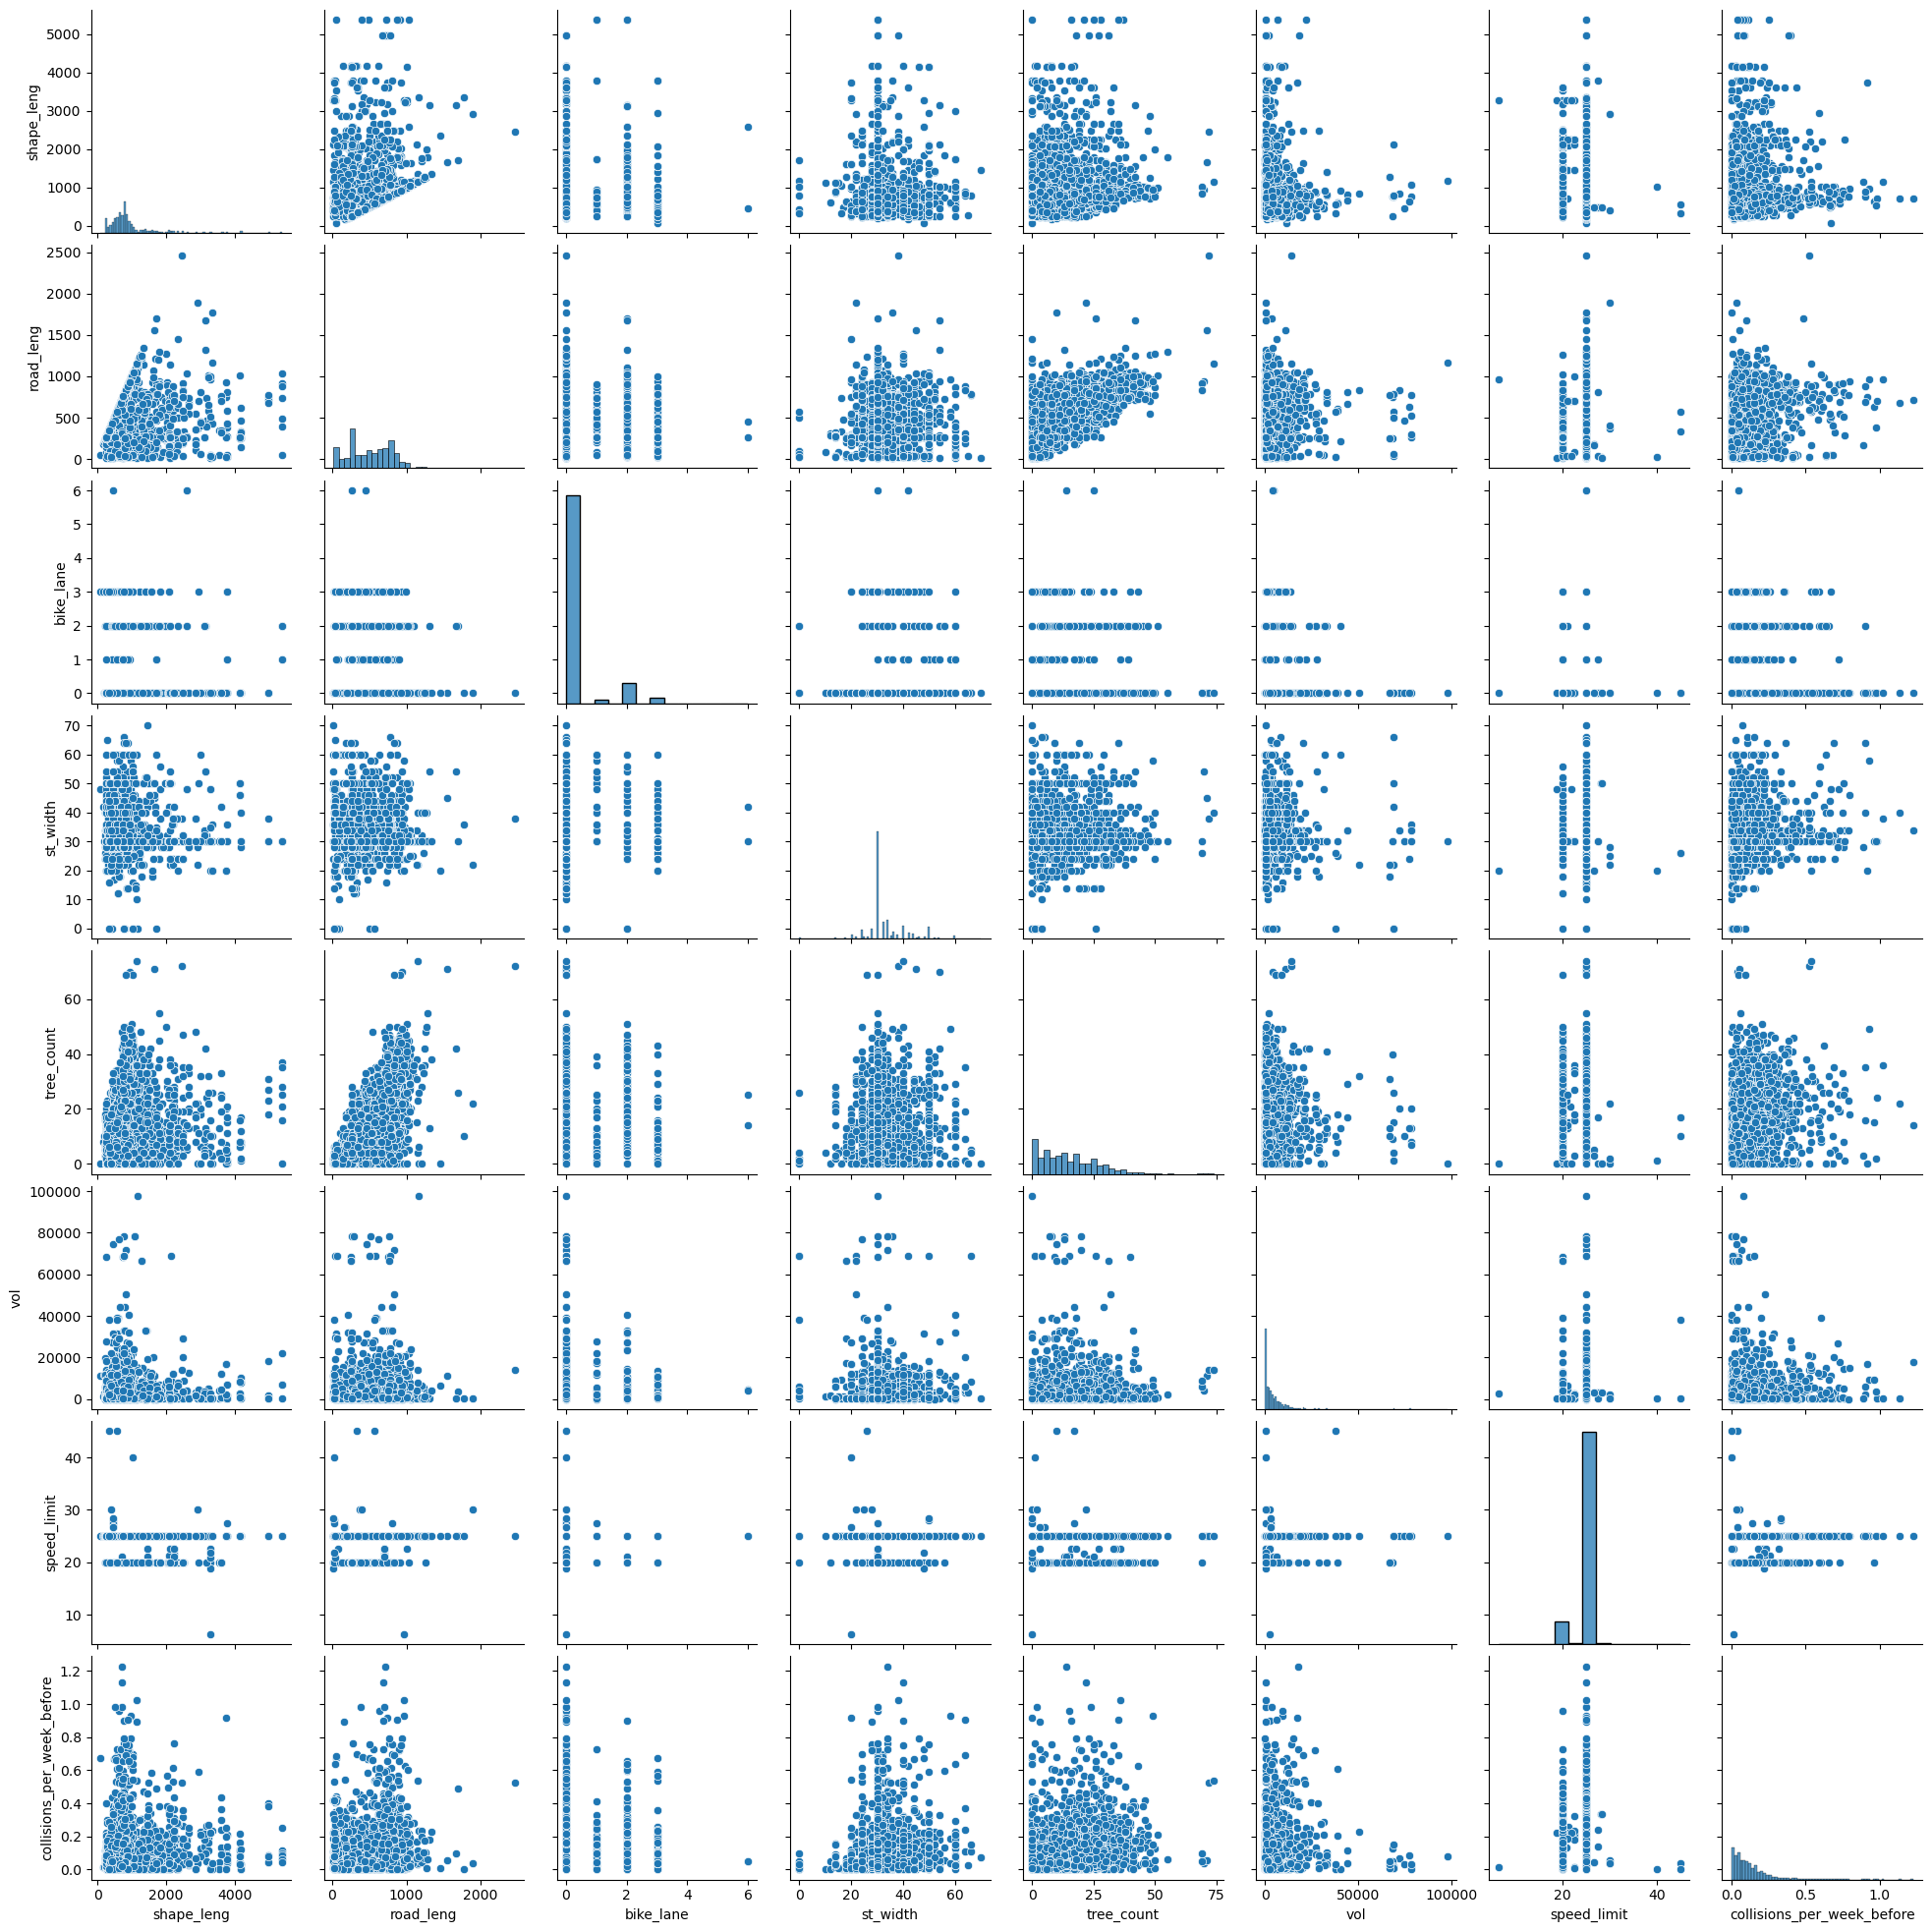

In [9]:
sns.pairplot(X_train)

In [10]:
y_train.describe()

count    2259.000000
mean        0.078716
std         0.083751
min         0.000000
25%         0.022746
50%         0.054670
75%         0.110148
max         1.007519
Name: collisions_per_week_after, dtype: float64

In [11]:
y_humps_train.describe()

count    2259.000000
mean        1.745905
std         1.363212
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: humps, dtype: float64

<Axes: xlabel='humps', ylabel='Count'>

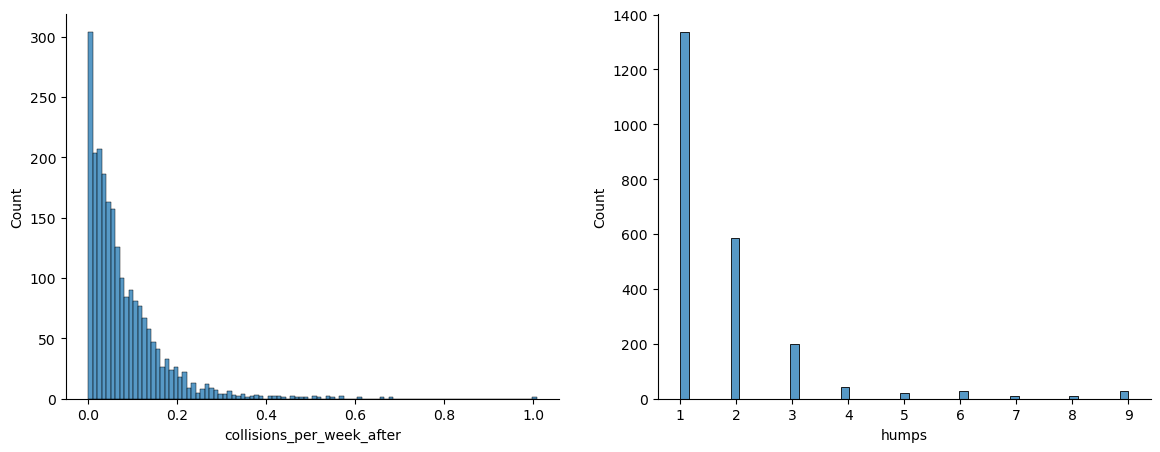

In [12]:
_, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(y_train, bins=100, ax=ax[0])
sns.histplot(y_humps_train, ax=ax[1])

#### Can we predict the number of humps?

I do not know, but this might be something we could try to do if we have time.

#### Linear models

In [13]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

In [14]:
X_train_single_feature = X_train[["collisions_per_week_before"]].copy()

In [15]:
from sklearn.model_selection import cross_val_score

mse_scores = cross_val_score(
    linear_model,
    X_train_single_feature,
    y_train,
    scoring="neg_mean_squared_error",
    cv=5,
)
r2_scores = cross_val_score(
    linear_model, X_train_single_feature, y_train, scoring="r2", cv=5
)

In [16]:
mse_scores, r2_scores

(array([-0.00190414, -0.00368823, -0.00194449, -0.00146864, -0.00220255]),
 array([0.74401791, 0.523036  , 0.73680759, 0.67677073, 0.71461742]))

In [48]:
mse_scores.mean(), r2_scores.mean()

(-0.0022416101537211775, 0.67904993009459)

In [55]:
from sklearn.metrics import mean_squared_error

baseline_model = linear_model.fit(X_train_single_feature, y_train)
y_preds = baseline_model.predict(X_train_single_feature)
mean_squared_error(y_train, y_preds)

0.0022233251694185447

In [19]:
import numpy as np

In [20]:
X_train["vol_per_leng"] = X_train["vol"] / X_train["road_leng"]
X_train["trees_per_leng"] = X_train["tree_count"] / X_train["road_leng"]
X_train["trees_per_vol"] = X_train["tree_count"] / (1 + X_train["vol"])

In [21]:
extended_mse_scores = cross_val_score(
    linear_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
)
extended_r2_scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring="r2")

In [22]:
extended_mse_scores, extended_r2_scores

(array([-0.00185857, -0.00373344, -0.00196627, -0.00144491, -0.00217303]),
 array([0.75014326, 0.5171896 , 0.73386089, 0.68199284, 0.71844292]))

In [23]:
extended_mse_scores.mean()

-0.002235242787180719

In [24]:
extended_linear_model = linear_model.fit(X_train, y_train)

In [25]:
y_preds = extended_linear_model.predict(X_train)
mean_squared_error(y_train, y_preds)

0.0021963524346774004

In [26]:
import pandas as pd

coefs = pd.DataFrame(
    extended_linear_model.coef_,
    index=extended_linear_model.feature_names_in_,
    columns=["coefficient"],
).sort_values(by="coefficient", ascending=False, key=abs)

In [27]:
coefs

,coefficient
collisions_per_week_before,4.950406e-01
trees_per_leng,-1.426448e-01
bike_lane,2.046826e-03
trees_per_vol,1.433109e-03
speed_limit,-7.382758e-04
tree_count,2.390885e-04
st_width,-1.381791e-04
shape_leng,2.289685e-06
road_leng,2.285108e-06
vol_per_leng,1.151401e-06


In [28]:
X_train["has_bike_lane"] = X["bike_lane"] > 0
X_train.drop(columns=["bike_lane", "shape_leng"], inplace=True)

In [29]:
extended_mse_scores_2 = cross_val_score(
    linear_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
)
extended_r2_scores_2 = cross_val_score(
    linear_model, X_train, y_train, cv=5, scoring="r2"
)

In [30]:
extended_mse_scores_2, extended_r2_scores_2

(array([-0.00185818, -0.00373027, -0.00195697, -0.0014483 , -0.00217988]),
 array([0.75019621, 0.51759962, 0.73511851, 0.68124733, 0.71755539]))

In [31]:
extended_mse_scores_2.mean()

-0.002234719056077387

In [32]:
extended_linear_model_2 = linear_model.fit(X_train, y_train)

In [33]:
y_preds = extended_linear_model_2.predict(X_train)

mean_squared_error(y_train, y_preds)

0.002197879873406286

In [34]:
coefs = pd.DataFrame(
    extended_linear_model.coef_,
    index=extended_linear_model.feature_names_in_,
    columns=["coefficient"],
).sort_values(by="coefficient", ascending=False, key=abs)
coefs

,coefficient
collisions_per_week_before,4.945795e-01
trees_per_leng,-1.413272e-01
has_bike_lane,6.224631e-03
trees_per_vol,1.432937e-03
speed_limit,-8.573840e-04
tree_count,2.324387e-04
st_width,-1.449270e-04
road_leng,2.879604e-06
vol_per_leng,1.027480e-06
vol,1.268194e-07


I will now try some automatic feature selection using Lasso regression.

In [35]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

alphas = np.linspace(0.000001, 0.01, 1000)
lasso_reg = Lasso(max_iter=100000, random_state=42)


def get_train_validation_scores(estimator, X, y, params, coefs=False):
    n_columns = X.shape[1]
    param_name = list(params.keys())[0]
    param_list = list(params.values())[0]
    n_params = len(param_list)
    if coefs:
        scores = np.zeros((n_params, n_columns + 3))
    else:
        scores = np.zeros((n_params, 3))
    for i, val in enumerate(param_list):
        param = {param_name: val}
        pipeline = Pipeline(
            [
                ("std_scaler", StandardScaler()),
                ("estimator", estimator.set_params(**param)),
            ]
        )
        cv_scores = cross_val_score(
            pipeline, X, y, cv=5, scoring="neg_mean_squared_error"
        )
        val_score = -cv_scores.mean()
        pipeline.fit(X, y)
        y_preds = pipeline.predict(X)
        train_score = mean_squared_error(y, y_preds)
        scores[i, 0] = val
        scores[i, 1] = val_score
        scores[i, 2] = train_score
        if coefs:
            scores[i, 3 : n_columns + 3] = pipeline["estimator"].coef_
    if coefs:
        df_cols = [param_name, "val_mse", "train_mse"] + list(X.columns)
    else:
        df_cols = [param_name, "val_mse", "train_mse"]
    return pd.DataFrame(scores, columns=df_cols)

In [36]:
lasso_coeff_df = get_train_validation_scores(
    lasso_reg, X_train, y_train, {"alpha": alphas}, coefs=True
)

In [37]:
lasso_coeff_df.head(10)

,alpha,val_mse,train_mse,road_leng,st_width,tree_count,vol,speed_limit,collisions_per_week_before,vol_per_leng,trees_per_leng,trees_per_vol,has_bike_lane
0,0.000001,0.002235,0.002198,0.000845,-0.001174,0.002651,0.001068,-0.001461,0.067979,0.000083,-0.002733,0.002530,0.002056
1,0.000011,0.002235,0.002198,0.000860,-0.001161,0.002615,0.001064,-0.001453,0.067975,0.000068,-0.002702,0.002520,0.002046
2,0.000021,0.002235,0.002198,0.000875,-0.001148,0.002580,0.001059,-0.001444,0.067971,0.000053,-0.002670,0.002509,0.002036
3,0.000031,0.002235,0.002198,0.000891,-0.001135,0.002543,0.001054,-0.001436,0.067968,0.000037,-0.002639,0.002498,0.002026
4,0.000041,0.002235,0.002198,0.000905,-0.001122,0.002508,0.001049,-0.001428,0.067964,0.000022,-0.002607,0.002488,0.002015
5,0.000051,0.002235,0.002198,0.000920,-0.001109,0.002472,0.001044,-0.001419,0.067960,0.000006,-0.002576,0.002477,0.002005
6,0.000061,0.002235,0.002198,0.000938,-0.001096,0.002437,0.001035,-0.001412,0.067956,0.000000,-0.002546,0.002466,0.001995
7,0.000071,0.002235,0.002198,0.000952,-0.001083,0.002407,0.001024,-0.001404,0.067951,0.000000,-0.002519,0.002456,0.001985
8,0.000081,0.002235,0.002198,0.000967,-0.001070,0.002378,0.001012,-0.001396,0.067946,0.000000,-0.002493,0.002445,0.001975
9,0.000091,0.002235,0.002198,0.000981,-0.001058,0.002349,0.001000,-0.001389,0.067941,0.000000,-0.002466,0.002434,0.001965


Text(0.0, 1.0, 'Validation and train MSEs')

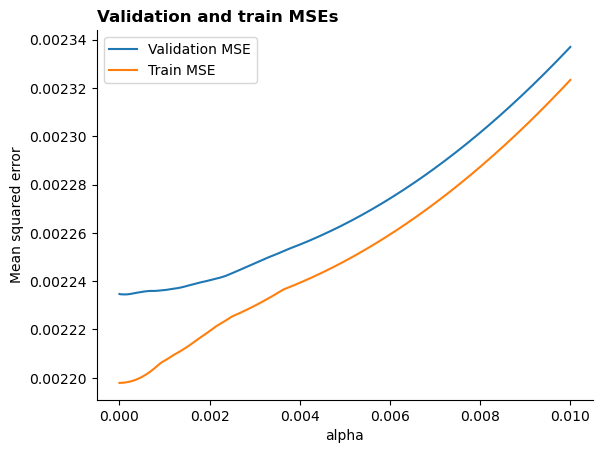

In [58]:
sns.lineplot(lasso_coeff_df, x="alpha", y="val_mse", label="Validation MSE")

sns.lineplot(lasso_coeff_df, x="alpha", y="train_mse", label="Train MSE")

plt.ylabel("Mean squared error")
plt.title("Validation and train MSEs")

In [39]:
best_alpha_ix = np.argmin(lasso_coeff_df["val_mse"].values)

In [40]:
best_alpha_ix

12

In [41]:
lasso_coeff_df.iloc[best_alpha_ix - 10 : best_alpha_ix + 10]

,alpha,val_mse,train_mse,road_leng,st_width,tree_count,vol,speed_limit,collisions_per_week_before,vol_per_leng,trees_per_leng,trees_per_vol,has_bike_lane
2,0.000021,0.002235,0.002198,0.000875,-0.001148,0.002580,0.001059,-0.001444,0.067971,0.000053,-0.002670,0.002509,0.002036
3,0.000031,0.002235,0.002198,0.000891,-0.001135,0.002543,0.001054,-0.001436,0.067968,0.000037,-0.002639,0.002498,0.002026
4,0.000041,0.002235,0.002198,0.000905,-0.001122,0.002508,0.001049,-0.001428,0.067964,0.000022,-0.002607,0.002488,0.002015
5,0.000051,0.002235,0.002198,0.000920,-0.001109,0.002472,0.001044,-0.001419,0.067960,0.000006,-0.002576,0.002477,0.002005
6,0.000061,0.002235,0.002198,0.000938,-0.001096,0.002437,0.001035,-0.001412,0.067956,0.000000,-0.002546,0.002466,0.001995
7,0.000071,0.002235,0.002198,0.000952,-0.001083,0.002407,0.001024,-0.001404,0.067951,0.000000,-0.002519,0.002456,0.001985
8,0.000081,0.002235,0.002198,0.000967,-0.001070,0.002378,0.001012,-0.001396,0.067946,0.000000,-0.002493,0.002445,0.001975
9,0.000091,0.002235,0.002198,0.000981,-0.001058,0.002349,0.001000,-0.001389,0.067941,0.000000,-0.002466,0.002434,0.001965
10,0.000101,0.002235,0.002198,0.001000,-0.001044,0.002314,0.000989,-0.001381,0.067936,0.000000,-0.002437,0.002423,0.001954
11,0.000111,0.002235,0.002198,0.001014,-0.001031,0.002285,0.000977,-0.001373,0.067931,0.000000,-0.002411,0.002412,0.001944


In [42]:
lasso_coeff_df.iloc[best_alpha_ix].sort_values(ascending=False, key=abs)

collisions_per_week_before    0.067926
trees_per_vol                 0.002401
trees_per_leng               -0.002385
tree_count                    0.002256
val_mse                       0.002235
train_mse                     0.002198
has_bike_lane                 0.001934
speed_limit                  -0.001366
road_leng                     0.001028
st_width                     -0.001019
vol                           0.000966
alpha                         0.000121
vol_per_leng                  0.000000
Name: 12, dtype: float64

I will try a linear model again using
- Collisions per week
- Presence of bike lane
- Trees per length
- Trees per traffic volume
- Speed limit

In [43]:
X_train_few_features = X_train[
    [
        "collisions_per_week_before",
        "has_bike_lane",
        "trees_per_leng",
        "trees_per_vol",
        "speed_limit",
    ]
].copy()

In [44]:
scores_ff = cross_val_score(
    linear_model, X_train_few_features, y_train, cv=5, scoring="neg_mean_squared_error"
)
r2_scores_ff = cross_val_score(
    linear_model, X_train_few_features, y_train, cv=5, scoring="r2"
)

In [45]:
scores_ff.mean(), r2_scores.mean()

(-0.0022349017808349107, 0.67904993009459)

In [46]:
linear_model_ff = linear_model.fit(X_train_few_features, y_train)
y_preds = linear_model_ff.predict(X_train_few_features)
mean_squared_error(y_train, y_preds)

0.002209308439970333

I also tried a random forest model, but the the scores do not seem to really improve. I guess that this is not unexpected, as the relationship between the collision rates before speed humps were installed and after is clearly linear. I think we probably should go with the simple linear model that only takes the weekly collision rate before humps were installed and outputs the predicted collision rate after installation. Here's how this model compares with `linear_model_ff` when evaluated against the test dataset:

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin


class FeaturePreProcessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        has_bike_lane = X["bike_lane"] > 0
        trees_per_leng = X["tree_count"] / X["road_leng"]
        trees_per_vol = X["tree_count"] / (1 + X["vol"])
        collisions_per_week = X["collisions_per_week_before"]
        speed_limit = X["speed_limit"]
        return np.c_[
            collisions_per_week,
            has_bike_lane,
            trees_per_leng,
            trees_per_vol,
            speed_limit,
        ]

In [51]:
pipeline_ff = Pipeline(
    [("column_transf", FeaturePreProcessing()), ("linear_ff", linear_model_ff)]
)

In [53]:
y_preds = pipeline_ff.predict(X_test)
mean_squared_error(y_test, y_preds)

/home/pjlemos/anaconda3/envs/erdos_sp_2024/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


0.0022511415130168234

In [56]:
y_preds_baseline = baseline_model.predict(X_test[["collisions_per_week_before"]])
mean_squared_error(y_test, y_preds_baseline)

0.00224334396787594